# Figure 2: shuffling hyperedges of a given order

In [1]:
import argparse
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../src/")

import xgi
from reducibility_hg import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
out_dir = f"{results_dir}datasets/"

## Load data

In [95]:
datasets = [
    "email-enron",
    "email-eu",
    "hospital-lyon",
    "contact-high-school",
    "contact-primary-school",
    "tags-ask-ubuntu",
]

data_names = [
    "email-enron",
    "email-eu",
    "hospital-lyon",
    "contact-high-school",
    "contact-primary-school",
    "tags-ask-ubuntu",
    "congress-bills",
    "disgenenet",
    "diseasome",
    "ndc-substances",
    "coauth-mag-geology",
    "coauth-mag-history",
]

kk = 5
dataset = datasets[kk]
rescale_per_node = False

# compute only if not computed yet
tag = f"shuffling_{dataset}"
file_name = f"{out_dir}{tag}.npz"
if os.path.isfile(file_name):
    print(f"Dataset {dataset} was already computed and saved at {file_name}.")

try:
    if "PACS" in dataset:
        H0 = xgi.read_json(f"../data/{dataset}.json")  # not yet online
    else:
        H0 = xgi.load_xgi_data(dataset, max_order=None, cache=True)
except Exception as e:
    print(e)
    
print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=False, singletons=False, multiedges=False)
print(H0)


Hypergraph named tags-ask-ubuntu with 3029 nodes and 271233 hyperedges
max order: 4
Hypergraph named tags-ask-ubuntu with 3021 nodes and 145053 hyperedges


In [96]:
orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

# compute characteristic timescale
print("Computing characteristic tau...")
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale_per_node)

Computing characteristic tau...


In [97]:
d_shuffles = [3, 5, 7] # orders to shuffle
p_shuffle = 1 # probability of shuffling

Hs = []

# create copies of the hypergraph with edges shuffled
for d_shuffle in d_shuffles:
    if d_shuffle <= xgi.max_edge_order(H0):
        print(d_shuffle)
        Hs.append(shuffle_hyperedges(S=H0, order=d_shuffle, p=p_shuffle))

3


In [98]:
# compute message length
Ds_H = []
lZs_H = []
Qs_H = []

for H in tqdm([H0] + Hs):
    
    Ds_H_i, lZs_H_i, orders = compute_information(H, tau_c, rescale_per_node=rescale_per_node)
    Q_i = Ds_H_i + lZs_H_i
    
    Ds_H.append(Ds_H_i)
    lZs_H.append(lZs_H_i)
    Qs_H.append(Q_i)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

logm result may be inaccurate, approximate err = 4.139872182232195e-12
logm result may be inaccurate, approximate err = 4.097611108417193e-12
logm result may be inaccurate, approximate err = 4.139872182232195e-12
logm result may be inaccurate, approximate err = 4.200715802849714e-12
logm result may be inaccurate, approximate err = 4.139872182232195e-12
logm result may be inaccurate, approximate err = 4.059824959894267e-12
logm result may be inaccurate, approximate err = 4.139872182232195e-12
logm result may be inaccurate, approximate err = 4.139872182232195e-12


 50%|█████████████████████▌                     | 1/2 [34:44<34:44, 2084.38s/it]

logm result may be inaccurate, approximate err = 4.156995107389829e-12
logm result may be inaccurate, approximate err = 4.097611108417193e-12
logm result may be inaccurate, approximate err = 4.156995107389829e-12
logm result may be inaccurate, approximate err = 4.200715802849714e-12
logm result may be inaccurate, approximate err = 4.156995107389829e-12
logm result may be inaccurate, approximate err = 4.431910868231712e-12
logm result may be inaccurate, approximate err = 4.156995107389829e-12
logm result may be inaccurate, approximate err = 4.156995107389829e-12


 50%|███████████████████▌                   | 1/2 [1:09:11<1:09:11, 4151.14s/it]


KeyboardInterrupt: 

In [ ]:
np.savez(
    f"{out_dir}shuffled_{dataset}_ds_{d_shuffles}.npz",
    Ds_H=Ds_H,
    lZs_H=lZs_H,
    Qs_H=Qs_H,
    d_shuffles=d_shuffles,
    orders=orders,
    p_shuffle=p_shuffle,
    tau_c=tau_c
)

In [ ]:
fig, ax = plt.subplots(figsize=(3.4, 2.2))
    
ax.plot(orders, Qs_H[0], "o-", label=f"not shuffled", ms=10, mfc="white")    
ax.axvline(d_shuffles[0], ls="--", c=f"C0", zorder=-2, alpha=0.8)

for j, H in enumerate(Hs):
    ax.plot(orders, Qs_H[j+1], "o-", label=f"d={d_shuffles[j]} shuffled")

    ax.axvline(d_shuffles[j], ls="--", c=f"C{j+1}", zorder=-2, alpha=0.8)

ax.set_xlabel("Max order")
#ax.set_xticks(orders)

ax.set_ylabel("Quality function")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#ax.set_xlim([0, 20])

sb.despine()

fig.suptitle(f"{dataset} $p_s={p_shuffle}$")

fig_name = f"info_{dataset}_p_s_{p_shuffle}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
plt.savefig(f"{out_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(6.4, 2.2), sharey=True)
    
ax.plot(orders, Qs_H[0], "o-", label=f"not shuffled", ms=10, mfc="white")    
ax.axvline(d_shuffles[0], ls="--", c=f"C0", zorder=-2, alpha=0.8)

for j, H in enumerate(Hs):
    ax.plot(orders, Qs_H[j+1], "o-", label=f"d={d_shuffles[j]} shuffled")

    ax.axvline(d_shuffles[j], ls="--", c=f"C{j+1}", zorder=-2, alpha=0.8)

ax.set_xlabel("Max order")
#ax.set_xticks(orders)

ax.set_ylabel("Quality function")
#ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
#ax.set_xlim([0, 20])

ax2.plot(orders, Qs_H[0], "o-", label=f"not shuffled", ms=10, mfc="white")    
ax2.axvline(d_shuffles[0], ls="--", c=f"C0", zorder=-2, alpha=0.8)

for j, H in enumerate(Hs):
    ax2.plot(orders, Qs_H[j+1], "o-", label=f"d={d_shuffles[j]} shuffled")

    ax2.axvline(d_shuffles[j], ls="--", c=f"C{j+1}", zorder=-2, alpha=0.8)

ax2.set_xlabel("Max order")
#ax2.set_xticks(orders)

#ax2.set_ylabel("Quality function")
ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax2.set_xlim([0, 15])
ax2.set_title("zoom in")

sb.despine()

fig.suptitle(f"{dataset} $p_s={p_shuffle}$")

fig_name = f"info_{dataset}_p_s_{p_shuffle}" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

#plt.savefig(f"{out_dir}{fig_name}_zoom.png", dpi=250, bbox_inches="tight")
#plt.savefig(f"{out_dir}{fig_name}_zoom.pdf", dpi=250, bbox_inches="tight")

## all datasets

In [66]:
import glob

In [90]:
data = dict()

for file_name in glob.glob(f"{out_dir}shuffled*.npz"):
    
    data_i = np.load(file_name)
    
    dataset = file_name.split("/")[-1].split(".")[0].split("_")[1]
    
    #print(file_name)
    print(dataset)
    data[dataset] = {}
    data[dataset]["Qs_H"] = data_i["Qs_H"]
    data[dataset]["orders"] = data_i["orders"]
    data[dataset]["d_shuffles"] = data_i["d_shuffles"]


email-enron
contact-high-school
contact-primary-school
hospital-lyon


[ 3  5  7 11]
[ 3  5  7 11]
[ 3  5  7 11]
[ 3  5  7 11]


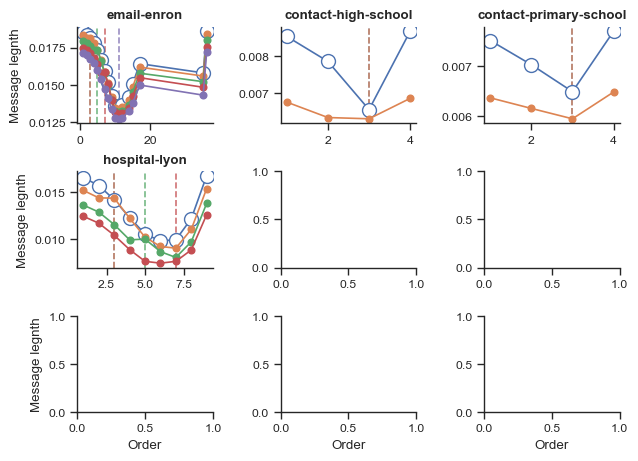

In [94]:
n_sets = len(data)

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(7, 5))

for i, (dataset, vals_dict) in enumerate(data.items()):

    ax = axs.flatten()[i]
    
    Qs_H = vals_dict["Qs_H"]
    orders = vals_dict["orders"]
    d_shuffles = vals_dict["d_shuffles"]
    print(d_shuffles)

    ax.plot(orders, Qs_H[0], "o-", label=f"not shuffled", ms=10, mfc="white")    
    ax.axvline(d_shuffles[0], ls="--", c=f"C0", zorder=-2, alpha=0.8)

    for j in range(len(Qs_H)-1):
        ax.plot(orders, Qs_H[j+1], "o-", label=f"d={d_shuffles[j]} shuffled")

        ax.axvline(d_shuffles[j], ls="--", c=f"C{j+1}", zorder=-2, alpha=0.8)

    ax.set_title(dataset, weight="bold")

plt.subplots_adjust(wspace=0.5, hspace=0.5)

for ax in axs[:, 0]:
    ax.set_ylabel("Message legnth")

for ax in axs[-1, :]:
    ax.set_xlabel("Order")
    
sb.despine()

fig_name = f"figure_2_v1" #lambda2_HG_SC_N_{N}_ps_{ps}_nrep_{n_repetitions}"

#plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")
#plt.savefig(f"{out_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight")